# Starter code for aicssegmentation of OHSU_BrCa data
This code is based on the Allen Institute's Cell Segmenter Python code. Please see the [aics-segmentation API Reference](https://github.com/AllenInstitute/aics-segmentation/blob/master/docs/API.md) for details about the functions.  

(NOTE: original author, Jianxu Chen jxchen01; modified by Darren Tyson)

In [1]:
import numpy as np
import os
from tifffile import imread, imsave

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk

from aicssegmentation.core.visual import blob2dExplorer_single, random_colormap
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, suggest_normalization_param, edge_preserving_smoothing_3d

#### To function properly you will need to correctly define `DATAPATH` as the top directory containing the example (or full) image datasets.
This may need to change once the data are made available across the instances.

In [2]:
DATAPATH = "./seg-image-subsets"

## load one example image

In [3]:
im_path = os.path.join(DATAPATH,'OHSU_slide001_scene004_nuclear001.tif')
im_path

'../OHSU_BrCa/OHSU_slide001_scene004_nuclear001.tif'

In [4]:
img = imread(im_path)

In [5]:
img.shape

(9430, 7597)

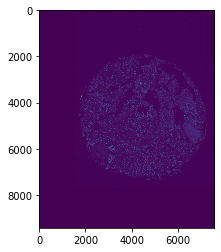

In [6]:
plt.imshow(img)

## crop a small area for algorithm development

In [7]:
img = img[2200:3000,3200:4000]

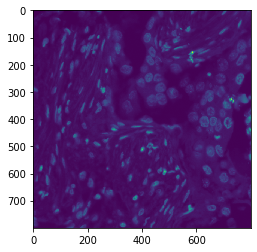

In [8]:
plt.imshow(img)

## pre-processing: intensity normalization and smoothing

In [9]:
suggest_normalization_param(img)

mean intensity of the stack: 1010.865465625
the standard deviation of intensity of the stack: 867.7045923515686
0.9999 percentile of the stack intensity is: 10200.000199999893
minimum intensity of the stack: 146
maximum intensity of the stack: 14619
suggested upper range is 11.0, which is 10555.615981492256
suggested lower range is 0.5, which is 577.0131694492156
So, suggested parameter for normalization is [0.5, 11.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [10]:
img_norm = intensity_normalization(img, [0.5, 11.0])

intensity normalization: normalize into [mean - 0.5 x std, mean + 11.0 x std] 
intensity normalization completes


In [11]:
img_smooth = edge_preserving_smoothing_3d(img_norm)

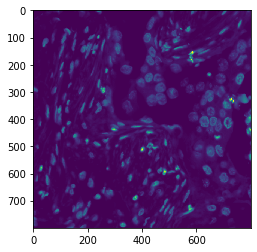

In [12]:
plt.imshow(img_smooth)

## try blob detection

In [13]:
interact(blob2dExplorer_single, im=fixed(img_smooth), \
         sigma=widgets.FloatRangeSlider(value=[1,5], min=1, max=11,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.05,min=0.01, max=0.5, step=0.01,continuous_update=False));

interactive(children=(FloatRangeSlider(value=(1.0, 5.0), continuous_update=False, description='sigma', max=11.…

## apply the optimal parameters found in previous step

In [14]:
img_dot_detection = dot_2d(img_smooth, 7)

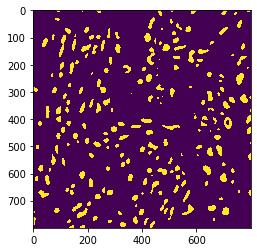

In [15]:
pre_mask = img_dot_detection>0.04
plt.imshow(pre_mask)

## use watershed to cut falsely merged nuclei

In [16]:
refined_mask = hole_filling(pre_mask, 1, 400)

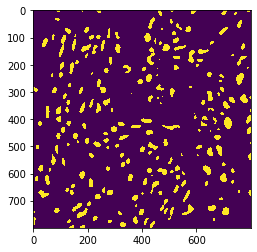

In [17]:
plt.imshow(refined_mask)

In [18]:
# watershed without seed in tik
watershed_map = -1*distance_transform_edt(refined_mask)
itk_raw = itk.GetImageFromArray(watershed_map.astype(np.float32))
watershed_result = itk.watershed_image_filter(itk_raw, threshold=0.1, level=0.5)
new_label = itk.GetArrayFromImage(watershed_result)

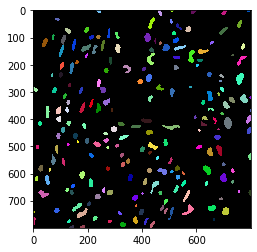

In [19]:
plt.imshow(new_label, cmap=random_colormap())

In [20]:
imsave('test_seg.tiff', new_label.astype(np.uint16))